(243000, 4)


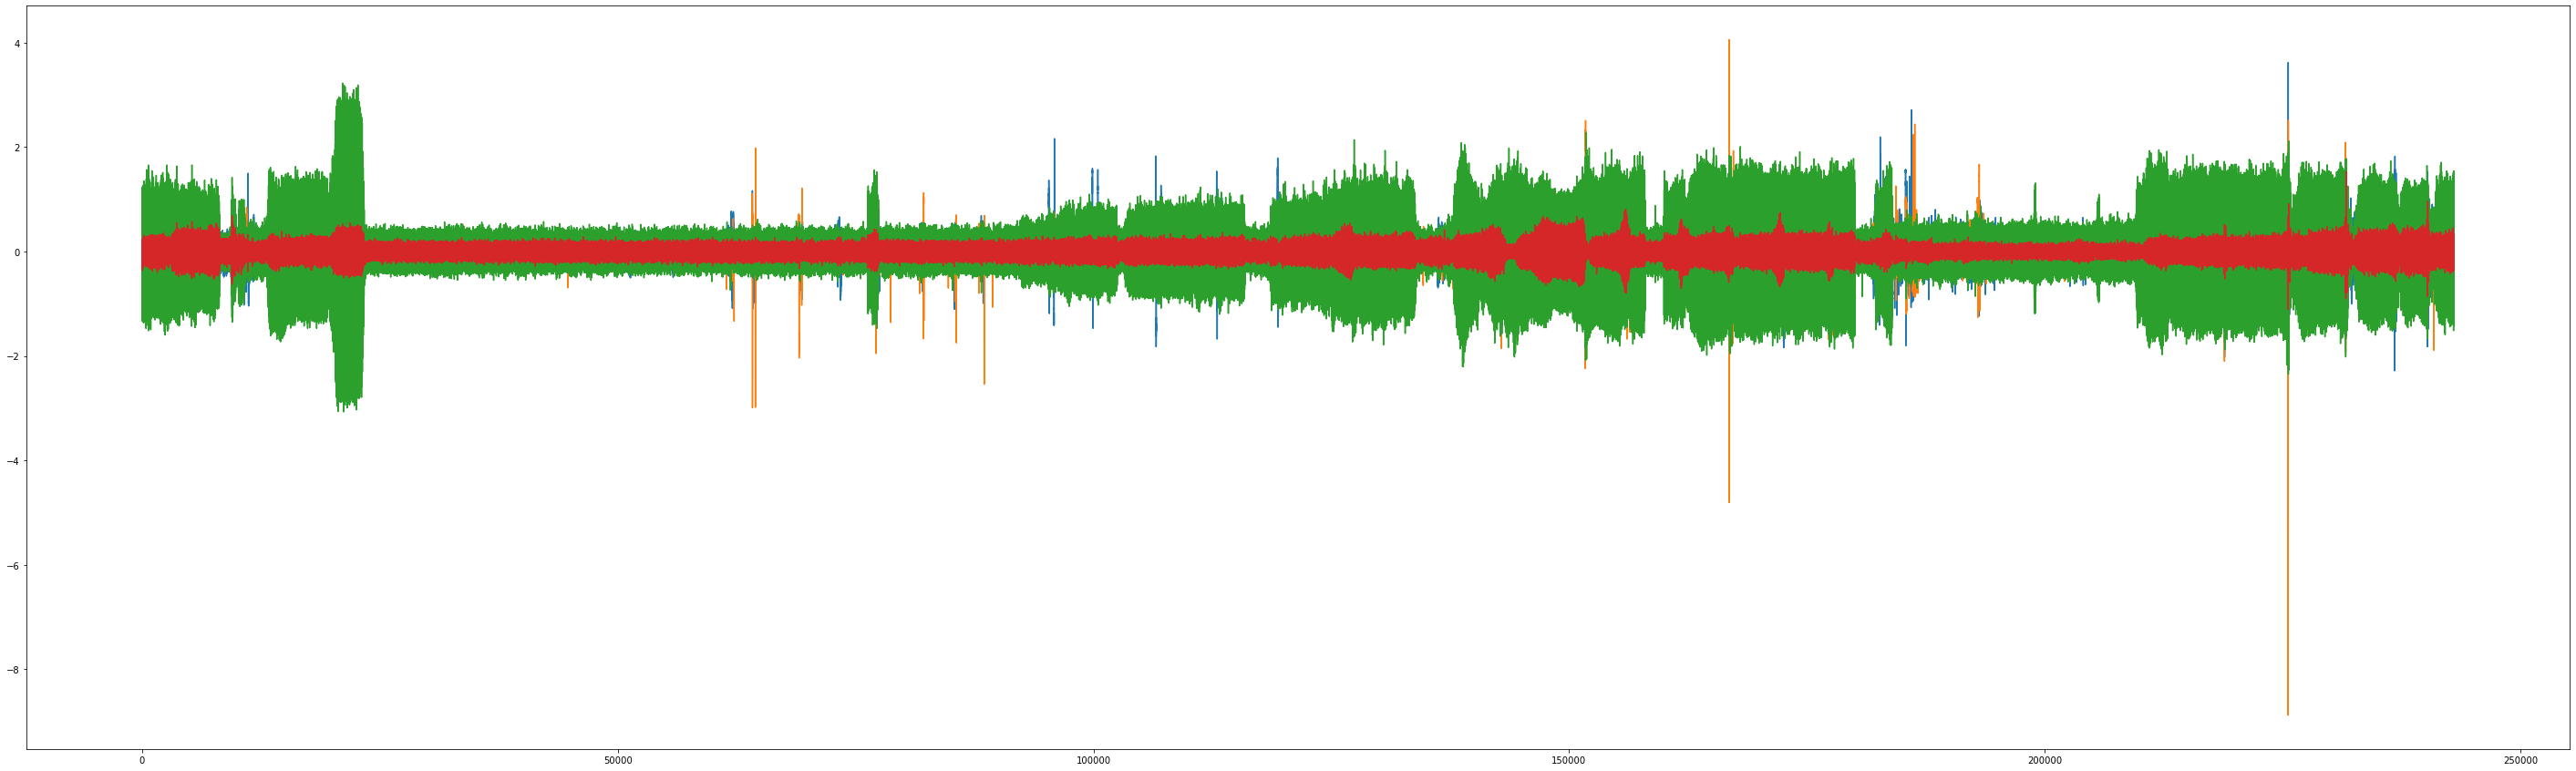

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# load pv data for continuous_1
path = '../dataset/pv/20230309/continuous_1.gz'
data = pd.read_csv(path, compression='gzip', skiprows=7, delimiter='\t',header=None)
start_s=0
end_s=243
ms=False
# data = data[:][:-7] #remove the final 7 rows for continuous_2 dataset
for j in range(len(data.columns)):
    data[j] = [float(i) for i in data[j]]
    
if not ms:  
    ts = data[0][1]-data[0][0]
    fs = int(np.rint(1/ts))
else:
    ts = (data[0][1]-data[0][0])/1000
    fs = int(np.rint(1/ts))

time = data[0][int(start_s*fs): int(end_s*fs)].to_numpy()-data[0][0]-start_s
pv = data[data.columns[1:]][int(start_s*fs): int(end_s*fs)].to_numpy()
audio = np.zeros(end_s*fs - start_s*fs)
pv_det = seasonal_decompose(pv, model='additive', period=75, extrapolate_trend='freq')
pv_denoised = pv-pv_det.trend
print(pv_denoised.shape)

fig = plt.figure(figsize=[50, 15])
plt.plot(pv_denoised)

[]
0
1
2
3
(487,)
(501, 487)


(1, 50)

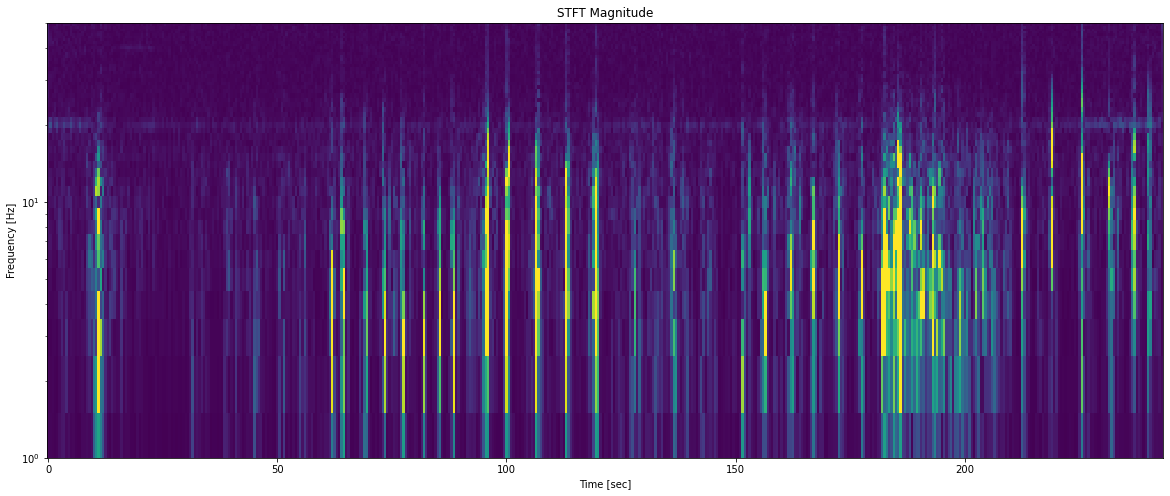

In [2]:
from scipy import signal

continuous_1=[]
print(continuous_1)
for ii in range(pv.shape[1]):
    print(ii)
# perform fft on pv data with window length of 0.1s
    f, t, Zxx = signal.stft(pv_denoised[:,ii], fs, nperseg=1000, axis=-1)
    continuous_1.append(Zxx)

print(np.shape(t))
print(continuous_1[1].shape)
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot()
# ax.set_xlim(0, 4860)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# print(f)
# print(fs)
plt.pcolormesh(t, f, np.abs(continuous_1[0]),vmax=0.1,vmin=0)
plt.yscale('log')
plt.ylim(1, 50)
# ax.imshow(np.abs(continuous_1[0]),vmax=0.05,vmin=0,interpolation='nearest',aspect='auto',extent=(np.max(np.abs(continuous_1[0])),np.min(np.abs(continuous_1[0])),np.max(f),np.min(f)))

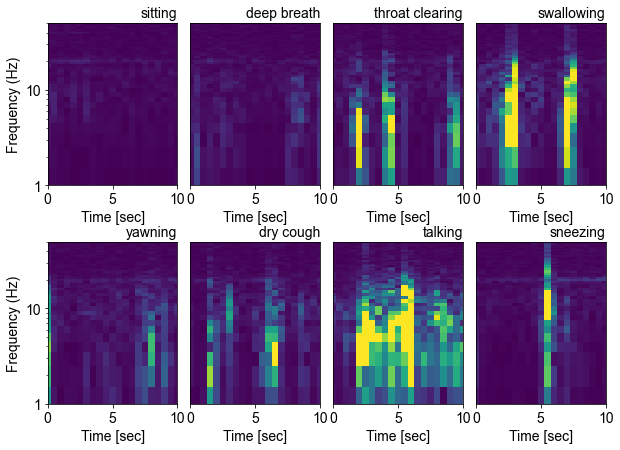

In [14]:
font = {'family': 'arial',
        'weight': 'normal',
        'size': 14,
        }

labels = ['sitting',
          'deep breath',
          'throat clearing',
          'swallowing',
          'yawning',
          'dry cough',
          'talking',
          'sneezing']
left_borders = np.array([20, 31, 60, 93, 120, 150, 180, 220])
right_borders = left_borders+10

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         figsize=[10, 7])
# fig.set_size(10, 7)
fig.subplots_adjust(hspace=0.35, wspace=0.1)

for i,(l,r) in enumerate(zip(left_borders, right_borders)):
    axes[i//4,i-i//4*4].pcolormesh(t, f, np.abs(continuous_1[0]),vmax=0.1,vmin=0)
    axes[i//4,i-i//4*4].set_xlim(l,r)
    axes[i//4,i-i//4*4].set_title(labels[i], x=1, ha='right', fontdict=font)
    axes[i//4,i-i//4*4].set_xticks([l,(l+r)/2,r])
    axes[i//4,i-i//4*4].set_xticklabels([0,5,10],fontdict=font)
    axes[i//4,i-i//4*4].set_xlabel('Time [sec]',fontdict=font)
    axes[i//4,i-i//4*4].set_ylim(1, 50)
    axes[i//4,i-i//4*4].set_yscale('log')
    if i%4==0:
        axes[i//4,i-i//4*4].set_ylabel('Frequency (Hz)', fontdict=font)
        axes[i//4,i-i//4*4].set_yscale('log')
        axes[i//4,i-i//4*4].set_yticks([1,10])
        axes[i//4,i-i//4*4].set_yticklabels([1,10], fontdict=font)
    else:
        axes[i//4,i-i//4*4].get_yaxis().set_visible(False)

plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, hidden_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, data):
        lstm_out, _ = self.lstm(data.view(-1, 1, len(data)))
        print(lstm_out.shape)
        print(len(lstm_out))
        tag_space = self.hidden2tag(lstm_out.view(len(lstm_out),-1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
INPUT_DIM = 4
HIDDEN_DIM = 6
TARGET_SIZE = 4

In [ ]:
target_1=torch.cat((torch.zeros(30000),
                    torch.ones(30000),
                    2*torch.ones(30000),
                    3*torch.ones(30000),
                    0)).type(torch.LongTensor)

In [5]:
model = LSTMTagger(INPUT_DIM, HIDDEN_DIM, TARGET_SIZE)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
print(len(continuous_1))
with torch.no_grad():
    inputs = torch.FloatTensor(continuous_1)
    tag_scores = model(inputs)
    print(tag_scores.size())
    print(tag_scores)
    test_loss = loss_function(tag_scores, target9)
    print(test_loss)

4


/var/folders/8z/m4kbswp17qq4hy08by5m6m800000gn/T/ipykernel_96334/4056032405.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  inputs = torch.FloatTensor(continuous_1)
/var/folders/8z/m4kbswp17qq4hy08by5m6m800000gn/T/ipykernel_96334/4056032405.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  inputs = torch.FloatTensor(continuous_1)


torch.Size([244851, 1, 6])
244851
torch.Size([244851, 4])
tensor([[-1.6903, -1.6484, -1.0711, -1.2710],
        [-1.7430, -1.7120, -0.9879, -1.3014],
        [-1.7515, -1.7222, -0.9754, -1.3065],
        ...,
        [-1.5172, -1.4079, -1.4775, -1.1783],
        [-1.5166, -1.4074, -1.4782, -1.1785],
        [-1.6179, -1.4963, -1.3368, -1.1550]])


NameError: name 'target9' is not defined